In [1]:
import pandas as pd
import numpy as np
import nltk
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, Bidirectional, 
                                      Conv1D, MaxPooling1D, Flatten, Input, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
# Ensure nltk dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')

In [4]:
# Preprocessing function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)


In [5]:
# Apply preprocessing
train['processed_text'] = train['text'].apply(preprocess_text)
train['processed_title'] = train['title'].apply(preprocess_text)
val['processed_text'] = val['text'].apply(preprocess_text)
val['processed_title'] = val['title'].apply(preprocess_text)
test['processed_text'] = test['text'].apply(preprocess_text)
test['processed_title'] = test['title'].apply(preprocess_text)


In [6]:
# Combine text and title
train['combined_text'] = train['processed_title'] + " " + train['processed_text']
val['combined_text'] = val['processed_title'] + " " + val['processed_text']
test['combined_text'] = test['processed_title'] + " " + test['processed_text']

In [8]:
# Prepare data for the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

max_length = 100
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post')

# Labels
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [9]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

In [10]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [24]:
# Combined RNN and CNN Model
input_layer = Input(shape=(max_length,))

In [25]:
# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, 
                             output_dim=100, 
                             weights=[embedding_matrix], 
                             input_length=max_length, 
                             trainable=False)(input_layer)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
# RNN branch
rnn_branch = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
rnn_branch = Dropout(0.5)(rnn_branch)
rnn_branch = LSTM(256)(rnn_branch)
rnn_branch = Dropout(0.5)(rnn_branch)

In [27]:
# CNN branch
cnn_branch = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

In [28]:
# Concatenate branches
combined_branch = Concatenate()([rnn_branch, cnn_branch])
combined_branch = Dense(64, activation='relu')(combined_branch)
combined_branch = Dropout(0.3)(combined_branch)
output_layer = Dense(1, activation='sigmoid')(combined_branch)


In [29]:
# Create model
combined_model = Model(inputs=input_layer, outputs=output_layer)

In [30]:
# Compile model
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Model summary
combined_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │  5,786,300 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 512)  │    731,136 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100, 512)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 128)   │     64,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    787,456 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 48, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6144)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6400)      │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    409,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,778,749 (29.67 MB)

 Trainable params: 1,992,449 (7.60 MB)

 Non-trainable params: 5,786,300 (22.07 MB)

In [32]:
# Training parameters
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_combined_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [33]:
# Train combined model
print("Training Combined RNN and CNN model...")
combined_history = combined_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20, batch_size=64, verbose=1, callbacks=callbacks
)

# Evaluate Combined Model
print("Evaluating Combined Model...")
y_pred_combined = (combined_model.predict(X_test_pad) > 0.5).astype('int32')
print("Combined Model Accuracy:", accuracy_score(y_test, y_pred_combined))
print(classification_report(y_test, y_pred_combined))


Training Combined RNN and CNN model...
Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.6573 - loss: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.82196, saving model to best_combined_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6584 - loss: 0.7248 - val_accuracy: 0.8220 - val_loss: 0.3844
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8513 - loss: 0.3403
Epoch 2: val_accuracy improved from 0.82196 to 0.84692, saving model to best_combined_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8514 - loss: 0.3402 - val_accuracy: 0.8469 - val_loss: 0.3490
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.8932 - loss: 0.2655
Epoch 3: val_accuracy did not improve from 0.84692
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 895ms/step - accuracy: 0.8932 - loss: 0.2654 - val_accuracy: 0.7903 - val_loss: 0.3971
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9283 - loss: 0.1990
Epoch 4: val_accuracy did not improve from 0.84692
76/76 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9283 - loss: 0.1989 - val_accuracy: 0.8453 - val_loss: 0.3892
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9681 - loss: 0.1044
Epoch 5: val_accuracy did not improve from 0.84692
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 733ms/step - accuracy: 0.9680 - loss: 0.1045 - val_accuracy: 0.8353 - val_loss: 0.3912
Evaluating Combined Model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
Combined Model Accuracy: 0.8352745424292846
            

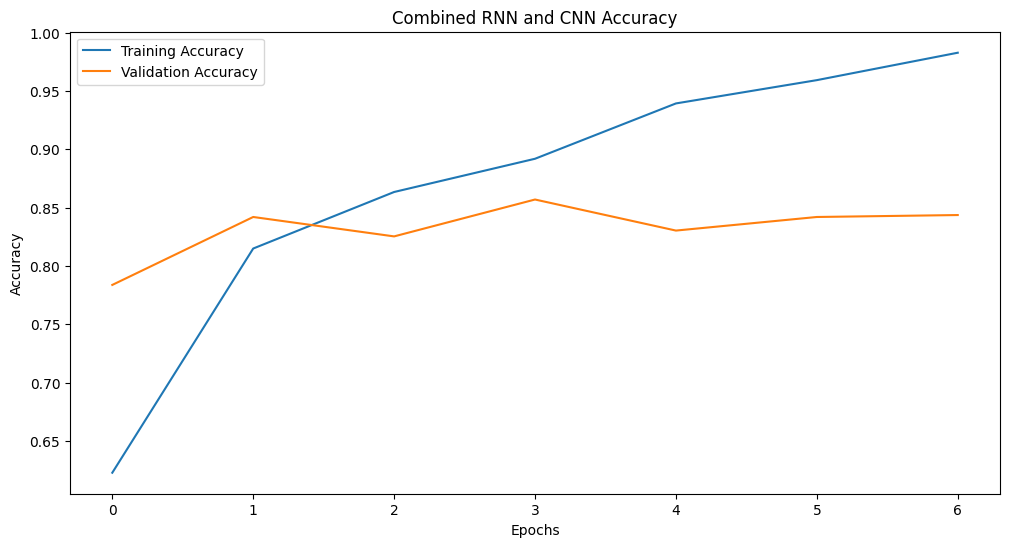

In [21]:
# Visualization helper function
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot accuracy
plot_history(combined_history, 'Combined RNN and CNN')

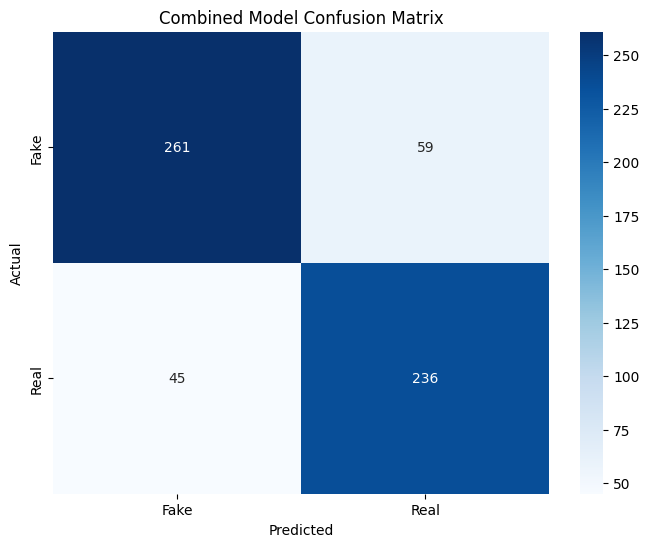

In [22]:
# Plot confusion matrix
conf_matrix_combined = confusion_matrix(y_test, y_pred_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Combined Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

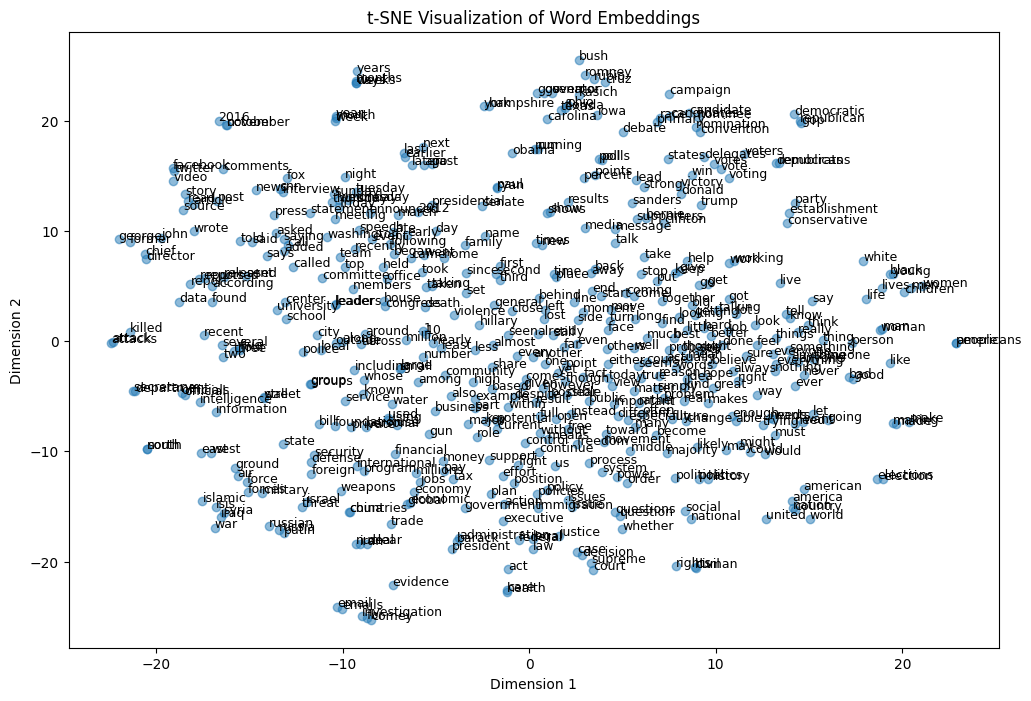

In [23]:
# t-SNE visualization for Word2Vec
words = list(w2v_model.wv.index_to_key)
word_vectors = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors[:500])

plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)
for i, word in enumerate(words[:500]):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()